In [1]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from abc import ABCMeta, abstractmethod

%matplotlib inline
plt.rcParams['axes.unicode_minus']=False
engine = create_engine('sqlite:///fund.db')

# 使用2017年的基金淨值進行測試

In [2]:
data = pd.read_sql(sql='select * from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date')

In [3]:
data

,id,NAV
date,,
2017-01-03,0050 元大台灣50,72.0300
2017-01-03,0051 元大中型100,25.6800
2017-01-03,0052 富邦科技,43.4000
2017-01-03,0053 元大電子,29.8400
2017-01-03,0054 元大台商50,21.3400
2017-01-03,0055 元大MSCI金融,14.5000
2017-01-03,0056 元大高股息,23.1800
2017-01-03,0057 富邦摩台,42.2800
2017-01-03,0058 富邦發達,40.2900


# 決定基金池

## 從所有基金裡隨機選出300檔做為基金池

In [4]:
random_names = data['id'].sample(n=300).values

In [5]:
random_names

array(['T4717D 台新北美收益 B$', 'FTZA8 富達歐洲大型企業', 'JFZAQ JPM 新企債券Adeh',
       'PIM53 PIMCO全高收M.iII', 'T05A6E 元大新亞USD債B$', 'MSZ22 摩士美國增長A',
       'T3741Y 國泰中國新興債券', 'T0737C 瀚亞全球高收債 C', 'CPA31 瀚亞日本股票A',
       'ALZY2 聯博新市債A.e', 'PIZ0006 鋒裕策收益U$md', 'T0934E 統一全球動多產AC',
       'ALZP2 聯博全球多元BX$', 'T1435E 新光新大東協債AC', 'T4123A 凱基護城河基金',
       'ALZJF 聯博全球價ADAUDH', 'T1042B 富邦中優債 B-CNY', 'SGF15 先機環策債Aa$',
       'PAZS7 法百亞債ex日RHDA', 'CTYN1 美盛美積成Aau.a', 'T2627A 中信全球股票息 A',
       'CTY35 美盛銳小A.EUR.D', 'NBZ10 NB美國房產I$a', 'T4222B 施2021新美主債B',
       'SGF62 先機環策債Bd$', 'EUZ56 歐義靈活策略息D', '00647L 元大S&P500正2',
       'T3221Y 野村鴻利', 'AFZ09 鋒裕長鷹多重FAC', 'ISZ53 景順泛歐洲Be',
       'ALZKJ 聯博全球多元A$', 'T1433A 新光美豐收平衡A', 'GSF89 天達環策管C2zmh',
       'NBZ10 NB美國房產I$a', 'TLZC9 安聯新興多元I$', 'T3806D 富達亞洲總報酬B$',
       'HHZ13 亨德森全地產A2$', 'DWS15 DWS可轉債LD', 'T2111C 柏瑞全球策高B-AU',
       'CPA18 瀚亞美優質債Adm', 'ANZA5 安本科技股票X$', 'ANZ33 安本日本股票AJPY',
       'T0344B 第一人幣貨幣 CNY', 'T0750A 瀚亞全球多重收A', 'SGF39 先機美入息AaEU',
       'SGF90 先機全新興Ba$'

# 抓出12月的資料以分群

In [6]:
month_data = data[data.index > '2017-12-01']

In [7]:
month_data = month_data[month_data.index < '2017-12-31']

In [8]:
month_data

,id,NAV
date,,
2017-12-04,0050 元大台灣50,83.1000
2017-12-04,0051 元大中型100,31.5100
2017-12-04,0052 富邦科技,53.9500
2017-12-04,0053 元大電子,36.2100
2017-12-04,0054 元大台商50,23.9300
2017-12-04,0055 元大MSCI金融,16.4100
2017-12-04,0056 元大高股息,24.9400
2017-12-04,0057 富邦摩台,50.0400
2017-12-04,0058 富邦發達,46.2200


# 找出12月所有有淨值的日子

In [9]:
month_date = pd.read_sql(sql='select distinct date from price where date between "2017-12-01" and "2017-12-31" order by date asc', con=engine,index_col='date').index

In [10]:
month_date

Index(['2017-12-01', '2017-12-04', '2017-12-05', '2017-12-06', '2017-12-07',
       '2017-12-08', '2017-12-11', '2017-12-12', '2017-12-13', '2017-12-14',
       '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
       '2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
       '2017-12-29'],
      dtype='object', name='date')

In [11]:
month_date_len = len(month_date)

# 拿出基金池裡的所有基金的12月淨值

In [12]:
month_NAV = np.zeros((300,month_date_len))

In [13]:
month_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
for j in range (300):
    temp = month_data[month_data['id'] == random_names[j]]
    month_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(month_date[1:]):
        try:
            month_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            month_NAV[j][i+1] = month_NAV[j][i]

In [15]:
for i in month_NAV[:50]:
    print (i)

[0.5183 0.5183 0.5153 0.5163 0.5201 0.5222 0.5213 0.5231 0.5245 0.5254
 0.5237 0.5243 0.5151 0.5105 0.5088 0.5123 0.5123 0.5147 0.519  0.5207
 0.5196]
[48.02 48.02 47.91 47.91 47.89 48.17 48.25 48.61 48.41 48.27 48.13 48.64
 48.42 48.08 48.32 48.32 48.32 48.32 48.32 48.32 48.32]
[72.34 72.34 72.69 72.73 72.66 72.62 72.67 72.66 72.67 72.68 72.74 72.76
 73.01 72.67 72.7  72.72 72.72 72.72 72.72 72.72 72.72]
[9.5  9.5  9.5  9.49 9.49 9.49 9.5  9.5  9.49 9.49 9.49 9.49 9.49 9.49
 9.49 9.49 9.49 9.49 9.49 9.49 9.49]
[ 9.9973  9.9973 10.0033 10.0146 10.0115 10.0028  9.9759  9.9696  9.9705
  9.9794  9.9798  9.9763  9.9667  9.9503  9.9473  9.9472  9.9472  9.9472
  9.9602  9.9672  9.9711]
[95.13 95.13 94.06 93.64 94.37 95.74 95.62 95.5  95.36 95.78 95.63 96.79
 96.62 96.22 96.19 95.93 95.93 95.93 95.93 95.93 95.93]
[ 9.9785  9.9785  9.9676  9.9768  9.976   9.9725  9.9728  9.9708  9.9854
  9.9859  9.975   9.9745  9.9729 10.0075 10.0021 10.0012 10.0406 10.022
 10.0182 10.0114 10.0486]
[9.4001 9.4

# 計算基金池裡的所有基金的12月漲跌幅

In [16]:
month_rate = np.zeros((300,month_date_len-1))

In [17]:
month_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
for j in range (300):
    for i in range (month_date_len-1):
        month_rate[j][i] = (month_NAV[j][i+1] - month_NAV[j][i]) / month_NAV[j][i]

In [19]:
for i in month_rate[:50]:
    print (i)

[ 0.         -0.00578815  0.00194062  0.00736006  0.00403769 -0.00172348
  0.00345291  0.00267635  0.00171592 -0.00323563  0.00114569 -0.01754721
 -0.0089303  -0.00333007  0.00687893  0.          0.00468476  0.00835438
  0.00327553 -0.00211254]
[ 0.         -0.00229071  0.         -0.00041745  0.00584673  0.00166078
  0.00746114 -0.00411438 -0.00289196 -0.00290035  0.0105963  -0.00452303
 -0.00702189  0.00499168  0.          0.          0.          0.
  0.          0.        ]
[ 0.          0.00483826  0.00055028 -0.00096246 -0.00055051  0.00068852
 -0.00013761  0.00013763  0.00013761  0.00082554  0.00027495  0.00343595
 -0.0046569   0.00041283  0.0002751   0.          0.          0.
  0.          0.        ]
[ 0.          0.         -0.00105263  0.          0.          0.00105374
  0.         -0.00105263  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
[ 0.00000000e+00  6.00162044e-04  1.12962722e-03 -3.

# 使用K-Means進行分群，並用MDS壓成2維座標，圖形化呈現

In [20]:
kmeans = KMeans(n_clusters=4, n_jobs=8).fit(month_rate)

In [21]:
mds = MDS(n_components=2, dissimilarity='euclidean', n_jobs=8).fit(month_rate).embedding_

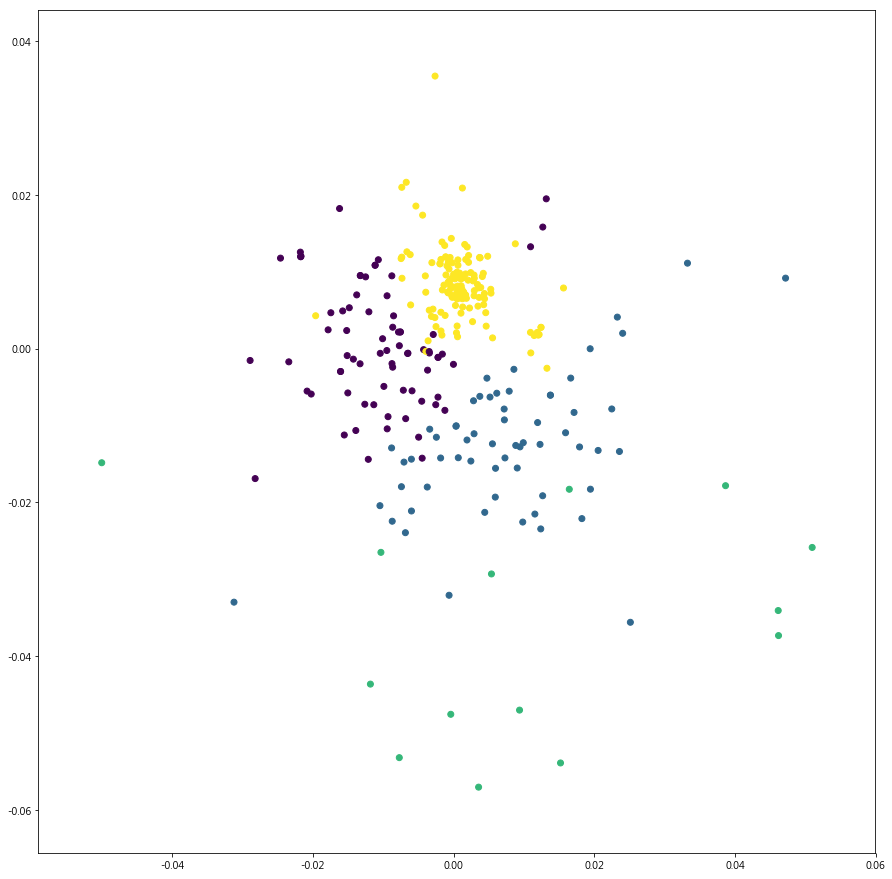

In [22]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=0.1)
plt.scatter(mds[:, 0], mds[:, 1], c=kmeans.labels_)

#for label, x, y in zip(random_names, mds[:, 0], mds[:, 1]):
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.show()

# 使用hierarchical進行分群，並用MDS壓成2維座標，圖形化呈現

In [23]:
hierarchical = AgglomerativeClustering(n_clusters=4).fit(month_rate)

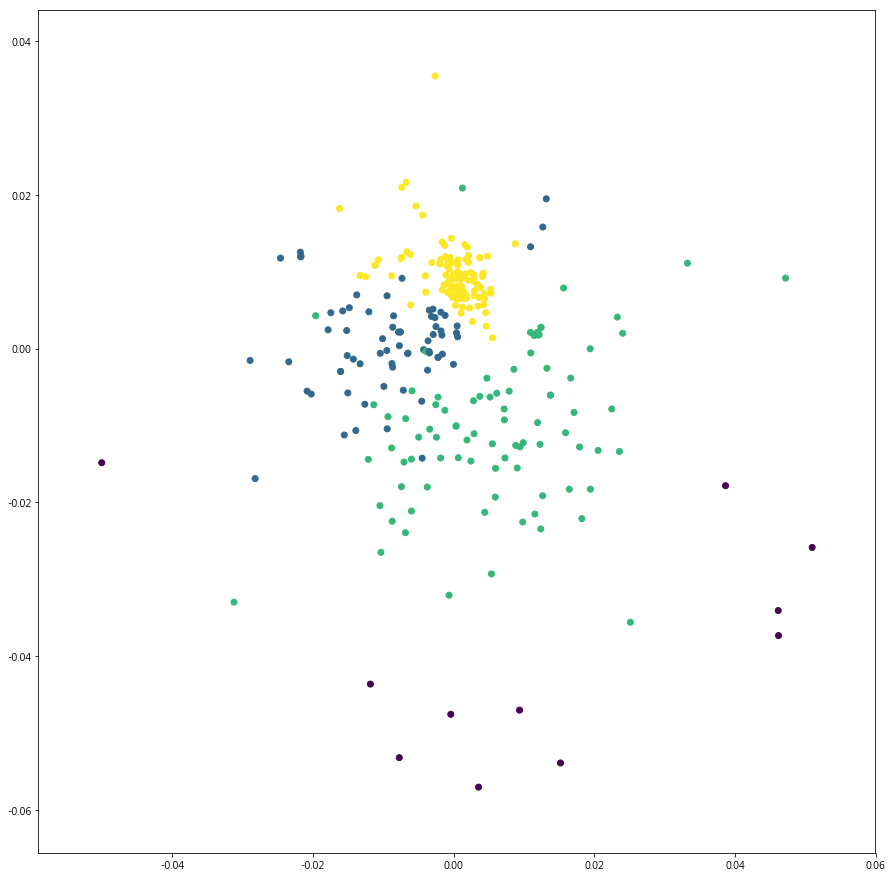

In [24]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=0.1)
plt.scatter(mds[:, 0], mds[:, 1], c=hierarchical.labels_)

#for label, x, y in zip(random_names, mds[:, 0], mds[:, 1]):
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.show()

# 開始進行收益率回測，對比對象為台灣50，時間範圍為2017年

In [25]:
camp = pd.DataFrame(data=kmeans.labels_, index=random_names,columns=['label'])

In [26]:
camp

,label
T4717D 台新北美收益 B$,0
FTZA8 富達歐洲大型企業,0
JFZAQ JPM 新企債券Adeh,3
PIM53 PIMCO全高收M.iII,3
T05A6E 元大新亞USD債B$,3
MSZ22 摩士美國增長A,0
T3741Y 國泰中國新興債券,3
T0737C 瀚亞全球高收債 C,3
CPA31 瀚亞日本股票A,1
ALZY2 聯博新市債A.e,3


# 從四個分群裡隨機選出4檔基金(K-Means)

In [27]:
choose_name = []
for i in range(4):
    choose_name.append(camp[camp['label'] == i].sample(n=1).index[0])

In [28]:
choose_name

['T0827Y 保德信全球基礎建', 'ANZA1 安本亞太股票X$', 'T0320Y 第一金中概平衡', 'NBZA6 NB新本地貨債C2$d']

In [29]:
choose_name.append('0050 元大台灣50')

In [30]:
choose_name

['T0827Y 保德信全球基礎建',
 'ANZA1 安本亞太股票X$',
 'T0320Y 第一金中概平衡',
 'NBZA6 NB新本地貨債C2$d',
 '0050 元大台灣50']

# 找出2017年所有有淨值的日子

In [31]:
year_date = pd.read_sql(sql='select distinct date from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date').index

In [32]:
year_date

Index(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09',
       '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
       ...
       '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
       '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29'],
      dtype='object', name='date', length=246)

In [33]:
year_date_len = len(year_date)

# 拿出四檔基金與台灣50，於2017年的所有淨值

In [34]:
year_NAV = np.zeros((5,year_date_len))

In [35]:
year_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
for j in range (5):
    temp = data[data['id'] == choose_name[j]]
    year_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(year_date[1:]):
        try:
            year_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            year_NAV[j][i+1] = year_NAV[j][i]

In [37]:
for i in year_NAV:
    print (i)

[11.42 11.49 11.47 11.49 11.47 11.34 11.35 11.39 11.35 11.35 11.4  11.35
 11.32 11.35 11.31 11.42 11.34 11.42 11.27 11.25 11.36 11.37 11.42 11.47
 11.39 11.37 11.4  11.38 11.38 11.38 11.44 11.38 11.35 11.28 11.41 11.37
 11.47 11.48 11.42 11.26 11.24 11.33 11.32 11.21 11.28 11.28 11.28 11.2
 11.16 11.22 11.23 11.29 11.22 11.24 11.3  11.3  11.34 11.37 11.48 11.48
 11.51 11.54 11.45 11.34 11.34 11.4  11.38 11.32 11.35 11.3  11.45 11.44
 11.38 11.4  11.43 11.47 11.43 11.38 11.52 11.48 11.46 11.53 11.46 11.51
 11.6  11.59 11.49 11.35 11.51 11.48 11.55 11.6  11.61 11.63 11.58 11.74
 11.79 11.79 11.76 11.75 11.69 11.68 11.72 11.69 11.78 11.82 11.74 11.9
 11.9  11.77 11.78 11.78 11.82 11.85 11.82 11.92 11.78 11.84 11.82 11.82
 11.78 11.78 11.81 11.83 11.82 11.93 11.92 12.03 12.03 12.07 12.12 12.18
 12.16 12.08 12.09 12.12 12.04 12.04 12.07 12.11 12.13 12.13 12.11 12.12
 12.06 12.04 11.98 11.98 12.07 12.06 12.13 12.04 12.06 12.08 12.12 12.13
 12.15 12.18 12.15 12.12 12.11 12.23 12.23 12.23 12.1

# 計算四檔基金與台灣50，於2017年的漲跌幅

In [38]:
year_rate = np.zeros((5,year_date_len-1))

In [39]:
year_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
for j in range (5):
    for i in range (year_date_len-1):
        year_rate[j][i] = (year_NAV[j][i+1] - year_NAV[j][i]) / year_NAV[j][i]

In [41]:
for i in year_rate:
    print (i)

[ 0.0061296  -0.00174064  0.00174368 -0.00174064 -0.01133391  0.00088183
  0.00352423 -0.00351185  0.          0.00440529 -0.00438596 -0.00264317
  0.00265018 -0.00352423  0.00972591 -0.00700525  0.00705467 -0.01313485
 -0.00177462  0.00977778  0.00088028  0.00439754  0.00437828 -0.00697472
 -0.00175593  0.00263852 -0.00175439  0.          0.          0.00527241
 -0.00524476 -0.0026362  -0.0061674   0.01152482 -0.0035057   0.00879507
  0.00087184 -0.00522648 -0.01401051 -0.0017762   0.00800712 -0.00088261
 -0.00971731  0.00624442  0.          0.         -0.0070922  -0.00357143
  0.00537634  0.00089127  0.00534283 -0.00620018  0.00178253  0.00533808
  0.          0.00353982  0.0026455   0.00967458  0.          0.00261324
  0.00260643 -0.00779896 -0.00960699  0.          0.00529101 -0.00175439
 -0.00527241  0.00265018 -0.00440529  0.01327434 -0.00087336 -0.00524476
  0.00175747  0.00263158  0.00349956 -0.00348736 -0.00437445  0.01230228
 -0.00347222 -0.00174216  0.0061082  -0.00607112  0

# 計算四檔基金的合計漲跌幅，並圖像化

In [42]:
choose_rate = []
for i in range(year_date_len-1):
    temp = (year_rate[0][i] + year_rate[1][i] + year_rate[2][i] + year_rate[3][i])/4
    choose_rate.append(temp)

In [43]:
choose_rate

[0.005427515693479079,
 0.006038786817858523,
 0.0008218881661716895,
 -0.003050941394041899,
 -0.0011528726562672785,
 -0.001978410184481768,
 0.009092239785690058,
 -0.0023320527787000973,
 -0.00287278559062278,
 0.004350319531899365,
 -0.0005498599239203822,
 -0.0026077069322152017,
 0.00139861966094266,
 0.006844274106468193,
 0.004941221853148704,
 0.006778565257187157,
 0.0023237824155006893,
 -0.0019793399200269033,
 -0.001459588623259198,
 0.001952599081084412,
 0.0023710430738687806,
 0.0039002371320531835,
 0.004006215444077567,
 -0.0020655735905073646,
 0.002574486324794606,
 0.00047795141088081505,
 -0.001936188535354874,
 0.0009896091044037394,
 -0.002118056839775145,
 0.0009473893345541301,
 0.0023404166505973127,
 0.0026117498219860886,
 -0.002036899725214808,
 0.0012691024991557207,
 -0.006587403648819736,
 -0.00014160580354463269,
 0.0034456233287635052,
 0.0009215137301263482,
 -0.00373193065442068,
 -0.006867814311803115,
 0.0042385768260350945,
 0.006168267090139402

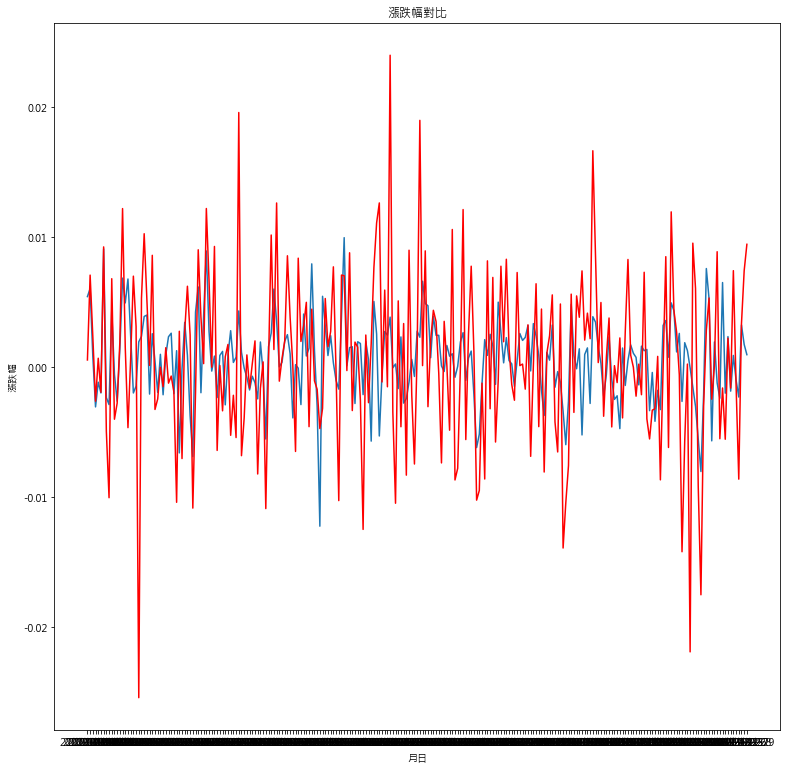

In [44]:
plt.figure(figsize=(13, 13))
plt.xlabel('月日')
plt.ylabel('漲跌幅')
plt.title('漲跌幅對比')
plt.plot(year_date[1:], choose_rate, label='四檔基金')
plt.plot(year_date[1:],year_rate[-1], color='r', label='台灣50')
plt.show()

# 計算四檔基金與台灣50，自2017年初至年尾的收益率，並圖像化

In [45]:
choose_profit = []
compare__profit = []
start = (year_NAV[0][0] + year_NAV[1][0] + year_NAV[2][0] + year_NAV[3][0])/4
for i in range(year_date_len-1):
    temp = (year_NAV[0][i] + year_NAV[1][i] + year_NAV[2][i] + year_NAV[3][i])/4
    temp = (temp-start)/start*100
    choose_profit.append(temp)
    compare__profit.append((year_NAV[4][i]-year_NAV[4][0])/year_NAV[4][0]*100)

In [46]:
choose_profit

[0.0,
 0.5548128204121442,
 1.1765751208293505,
 1.1883532700894914,
 0.7769445827745699,
 0.6339537180724389,
 0.4595544553432512,
 1.2811320247878477,
 1.0819366583530878,
 0.6949108063486319,
 1.1548785300869602,
 1.1096256408243033,
 0.7711588252432541,
 0.8870806100668002,
 1.6691910477800262,
 2.0665486096618086,
 2.8610570992278057,
 3.071410712330076,
 2.878827640216816,
 2.7955540586055876,
 2.9364785813322443,
 3.1751410794983745,
 3.6415144633606498,
 4.067594178701399,
 3.8150871892996534,
 4.1680183987089485,
 4.143222295003376,
 3.9865935732631983,
 4.151900931300335,
 3.778306302136402,
 3.8405031955978703,
 4.1204925332732785,
 4.316381752547273,
 4.089084135246206,
 4.089084135246206,
 3.5960549399004385,
 3.5524551242181492,
 3.9390677078275136,
 4.115533312532161,
 3.8694319832543616,
 3.186092691968332,
 3.4917046701395096,
 4.297371406373017,
 4.135370195496601,
 4.451933786137736,
 5.258840327556533,
 5.518992782267486,
 5.478492479548378,
 5.554740498443015,
 5.2

In [47]:
compare__profit

[0.0,
 0.05553241704844099,
 0.7635707344162115,
 0.9995835068721349,
 0.7358045258919911,
 0.8052200472025521,
 0.6108565875329692,
 1.541024573094543,
 1.0412328196584755,
 0.027766208524220494,
 0.7080383173677705,
 0.3054282937664846,
 0.027766208524220494,
 0.2221296681938034,
 1.4438428432597417,
 1.5965569901430037,
 1.1245314452311568,
 1.193946966541718,
 1.9019852839094884,
 2.2212966819380733,
 -0.37484381507704573,
 0.1527141468832423,
 1.1800638622795978,
 1.7076218242399057,
 1.7215049285020059,
 2.596140497015139,
 2.262945994724414,
 2.0130501180063898,
 2.0130501180063898,
 1.860335971123148,
 2.0130501180063898,
 1.8881021796473683,
 1.8186866583368073,
 1.6243231986672244,
 0.5692072747466286,
 0.8468693599888928,
 0.1388310426211222,
 0.41649312786338627,
 1.0412328196584755,
 1.2911286963764996,
 0.1943634596695829,
 0.0,
 0.9024017770373535,
 1.2911286963764996,
 1.3188949049007397,
 2.554491184228798,
 3.2347632930723282,
 3.2347632930723282,
 4.192697487158123,


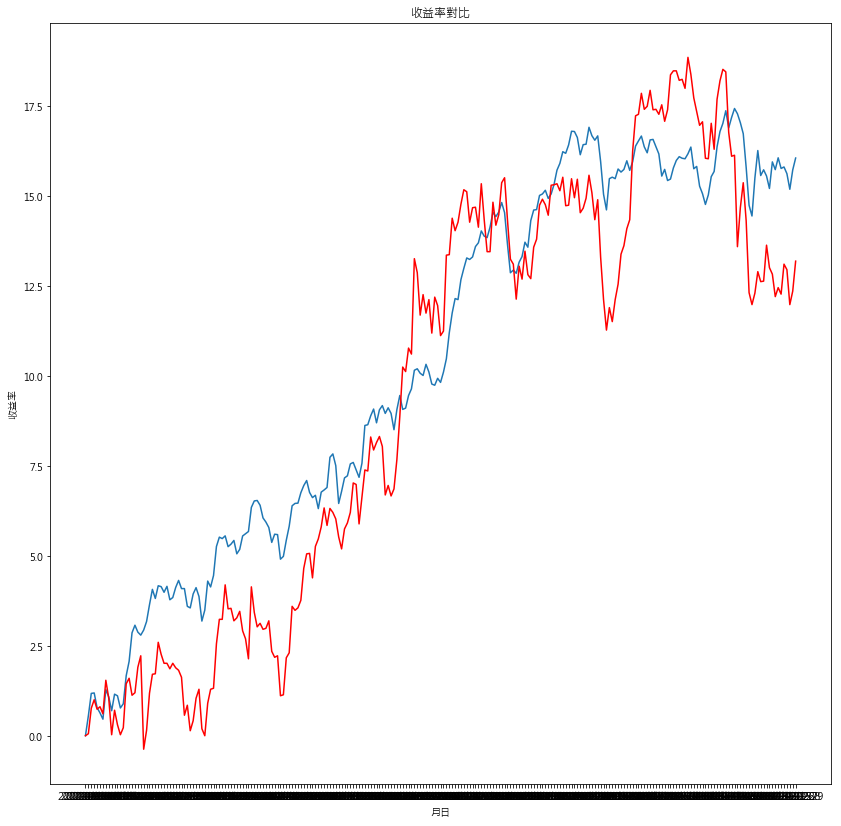

In [48]:
plt.figure(figsize=(14, 14))
plt.xlabel('月日')
plt.ylabel('收益率')
plt.title('收益率對比')
plt.plot(year_date[1:], choose_profit, label='四檔基金')
plt.plot(year_date[1:], compare__profit, color = 'r', label='台灣50')
plt.show()

In [49]:
camp = pd.DataFrame(data=hierarchical.labels_, index=random_names,columns=['label'])

In [50]:
camp

,label
T4717D 台新北美收益 B$,1
FTZA8 富達歐洲大型企業,1
JFZAQ JPM 新企債券Adeh,3
PIM53 PIMCO全高收M.iII,3
T05A6E 元大新亞USD債B$,3
MSZ22 摩士美國增長A,2
T3741Y 國泰中國新興債券,3
T0737C 瀚亞全球高收債 C,3
CPA31 瀚亞日本股票A,2
ALZY2 聯博新市債A.e,3


# 從四個分群裡隨機選出4檔基金(Hierarchical)

In [51]:
choose_name = []
for i in range(4):
    choose_name.append(camp[camp['label'] == i].sample(n=1).index[0])

In [52]:
choose_name

['T0568Y 元大績效基金', 'T4717D 台新北美收益 B$', 'PIZ0016 鋒裕新市貨債A$md', 'CPA18 瀚亞美優質債Adm']

In [53]:
choose_name.append('0050 元大台灣50')

In [54]:
choose_name

['T0568Y 元大績效基金',
 'T4717D 台新北美收益 B$',
 'PIZ0016 鋒裕新市貨債A$md',
 'CPA18 瀚亞美優質債Adm',
 '0050 元大台灣50']

# 找出2017年所有有淨值的日子

In [55]:
year_date = pd.read_sql(sql='select distinct date from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date').index

In [56]:
year_date

Index(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09',
       '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
       ...
       '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
       '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29'],
      dtype='object', name='date', length=246)

In [57]:
year_date_len = len(year_date)

# 拿出四檔基金與台灣50，於2017年的所有淨值

In [58]:
year_NAV = np.zeros((5,year_date_len))

In [59]:
year_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
for j in range (5):
    temp = data[data['id'] == choose_name[j]]
    year_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(year_date[1:]):
        try:
            year_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            year_NAV[j][i+1] = year_NAV[j][i]

In [61]:
for i in year_NAV:
    print (i)

[37.01 37.13 37.62 37.71 37.32 37.35 37.17 37.37 37.22 37.02 37.33 37.53
 37.34 37.38 37.65 37.82 37.81 38.25 38.66 38.68 38.91 39.29 39.26 39.39
 39.28 39.42 39.07 39.1  39.42 39.18 39.24 39.63 39.8  39.61 39.51 39.45
 39.45 39.88 39.86 39.87 39.63 39.32 39.56 39.67 39.48 39.65 40.13 40.03
 40.09 40.02 40.05 39.9  39.4  39.34 39.62 39.68 39.63 40.31 40.19 40.26
 40.17 39.74 39.75 39.78 39.22 39.34 39.89 39.71 39.67 40.14 39.8  40.42
 40.65 40.78 40.83 40.97 40.7  40.9  40.58 40.41 40.02 40.71 40.72 40.98
 41.29 40.93 40.84 40.78 40.76 41.14 41.24 41.52 41.79 41.59 41.49 41.61
 41.91 42.24 42.64 42.63 42.41 42.84 42.6  42.57 42.27 41.38 41.51 41.8
 41.93 41.78 42.27 42.53 42.43 42.84 42.9  42.58 42.46 42.3  42.19 42.1
 42.1  42.24 42.09 42.1  42.54 43.22 43.79 44.1  44.18 44.97 45.11 45.13
 45.01 45.23 45.59 45.71 45.92 44.96 44.92 45.02 45.55 45.39 45.7  46.18
 45.99 45.16 44.66 44.72 43.98 44.64 44.54 45.2  45.05 44.93 45.21 45.31
 45.7  46.02 46.45 46.6  47.09 47.26 47.53 47.42 48.0

# 計算四檔基金與台灣50，於2017年的漲跌幅

In [62]:
year_rate = np.zeros((5,year_date_len-1))

In [63]:
year_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
for j in range (5):
    for i in range (year_date_len-1):
        year_rate[j][i] = (year_NAV[j][i+1] - year_NAV[j][i]) / year_NAV[j][i]

In [65]:
for i in year_rate:
    print (i)

[ 0.00324237  0.01319688  0.00239234 -0.01034208  0.00080386 -0.00481928
  0.00538068 -0.00401391 -0.00537346  0.00837385  0.00535762 -0.00506262
  0.00107124  0.00722311  0.00451527 -0.00026441  0.01163713  0.01071895
  0.00051733  0.00594623  0.00976613 -0.00076355  0.00331126 -0.00279259
  0.00356415 -0.00887874  0.00076785  0.00818414 -0.00608828  0.00153139
  0.00993884  0.00428968 -0.00477387 -0.00252461 -0.0015186   0.
  0.01089987 -0.0005015   0.00025088 -0.00601956 -0.00782236  0.00610376
  0.00278059 -0.00478951  0.00430598  0.01210593 -0.0024919   0.00149888
 -0.00174607  0.00074963 -0.00374532 -0.01253133 -0.00152284  0.00711744
  0.00151439 -0.00126008  0.01715872 -0.00297693  0.00174173 -0.00223547
 -0.01070451  0.00025164  0.00075472 -0.01407743  0.00305966  0.01398068
 -0.00451241 -0.0010073   0.01184774 -0.00847035  0.01557789  0.00569025
  0.00319803  0.00122609  0.00342885 -0.00659019  0.004914   -0.00782396
 -0.00418926 -0.00965108  0.01724138  0.00024564  0.0063850

# 計算四檔基金的合計漲跌幅，並圖像化

In [66]:
choose_rate = []
for i in range(year_date_len-1):
    temp = (year_rate[0][i] + year_rate[1][i] + year_rate[2][i] + year_rate[3][i])/4
    choose_rate.append(temp)

In [67]:
choose_rate

[0.006164009599695908,
 0.004710966551440373,
 0.001245425687780015,
 -0.004149376864511173,
 -0.0013461659020391598,
 -0.0024820820176268223,
 0.002276630339308559,
 -0.0024455865030357064,
 -0.001343363782912384,
 0.005391423130138516,
 -0.00034871547267975535,
 -0.004103571423215759,
 0.0013696719511525762,
 0.004581627237615822,
 0.0018364192750448948,
 -0.005634303153467732,
 0.004367916500723725,
 0.0020003025591599243,
 -8.847119793387997e-05,
 0.004995050559025059,
 0.0022662647060701694,
 0.0006514059387671556,
 0.0009625442297176512,
 -0.0018486822372439336,
 -0.000605160919264736,
 -0.0014589691127190637,
 0.0018891476498149457,
 0.0020460358056266,
 -0.0015220700152207126,
 0.002497248221249557,
 0.0022248562026821734,
 0.0026937005379615983,
 -7.370102704363666e-05,
 -0.0019398005113642688,
 -0.0024569960913473137,
 -0.0007563249923473179,
 0.00158841043519101,
 -0.0013100093653063,
 -0.0046413981753495905,
 -0.0053602711500455235,
 -0.0031488045800592175,
 0.0018968421022

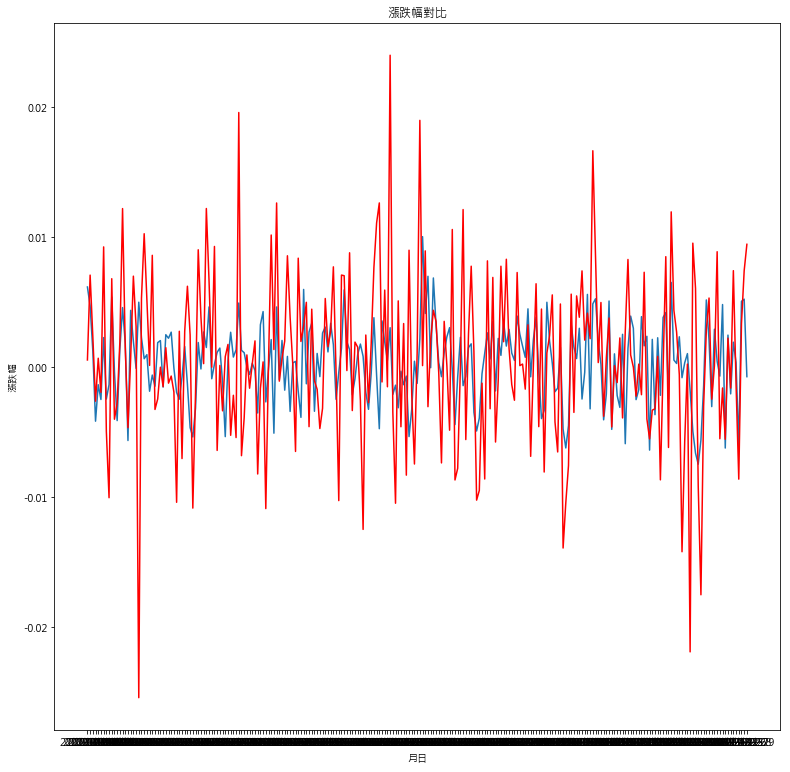

In [68]:
plt.figure(figsize=(13, 13))
plt.xlabel('月日')
plt.ylabel('漲跌幅')
plt.title('漲跌幅對比')
plt.plot(year_date[1:], choose_rate, label='四檔基金')
plt.plot(year_date[1:],year_rate[-1], color='r', label='台灣50')
plt.show()

# 計算四檔基金與台灣50，自2017年初至年尾的收益率，並圖像化

In [69]:
choose_profit = []
compare__profit = []
start = (year_NAV[0][0] + year_NAV[1][0] + year_NAV[2][0] + year_NAV[3][0])/4
for i in range(year_date_len-1):
    temp = (year_NAV[0][i] + year_NAV[1][i] + year_NAV[2][i] + year_NAV[3][i])/4
    temp = (temp-start)/start*100
    choose_profit.append(temp)
    compare__profit.append((year_NAV[4][i]-year_NAV[4][0])/year_NAV[4][0]*100)

In [70]:
choose_profit

[0.0,
 0.16210662276866325,
 0.684081913059025,
 0.803703342871581,
 0.41551121337912533,
 0.4482539389197592,
 0.25139583444234415,
 0.4907391318758521,
 0.27650528654404694,
 0.07562966973036747,
 0.46874325183475074,
 0.6401905907852466,
 0.3733273338482487,
 0.3974324078659068,
 0.7088900517355116,
 0.9003245145589623,
 0.836546506220625,
 1.2794772412948017,
 1.6975998376925059,
 1.7326526328264882,
 2.0294463566687204,
 2.388611959531605,
 2.3255370158520963,
 2.453494783762426,
 2.3396987468374606,
 2.439734804010688,
 2.108993100926928,
 2.19165341724578,
 2.5130544041476783,
 2.2720036639712404,
 2.3202138120065423,
 2.7402447267639687,
 2.9191244635365607,
 2.7306026971569053,
 2.6274530679230765,
 2.5090368918114136,
 2.5132552797644987,
 2.9447361046803002,
 2.910687687630377,
 2.8649884848052585,
 2.5911950190882145,
 2.25050997297219,
 2.4999974890547976,
 2.5963173473169485,
 2.4189441776704514,
 2.6387021024646313,
 3.142297273816572,
 3.049994927890686,
 3.145611721494

In [71]:
compare__profit

[0.0,
 0.05553241704844099,
 0.7635707344162115,
 0.9995835068721349,
 0.7358045258919911,
 0.8052200472025521,
 0.6108565875329692,
 1.541024573094543,
 1.0412328196584755,
 0.027766208524220494,
 0.7080383173677705,
 0.3054282937664846,
 0.027766208524220494,
 0.2221296681938034,
 1.4438428432597417,
 1.5965569901430037,
 1.1245314452311568,
 1.193946966541718,
 1.9019852839094884,
 2.2212966819380733,
 -0.37484381507704573,
 0.1527141468832423,
 1.1800638622795978,
 1.7076218242399057,
 1.7215049285020059,
 2.596140497015139,
 2.262945994724414,
 2.0130501180063898,
 2.0130501180063898,
 1.860335971123148,
 2.0130501180063898,
 1.8881021796473683,
 1.8186866583368073,
 1.6243231986672244,
 0.5692072747466286,
 0.8468693599888928,
 0.1388310426211222,
 0.41649312786338627,
 1.0412328196584755,
 1.2911286963764996,
 0.1943634596695829,
 0.0,
 0.9024017770373535,
 1.2911286963764996,
 1.3188949049007397,
 2.554491184228798,
 3.2347632930723282,
 3.2347632930723282,
 4.192697487158123,


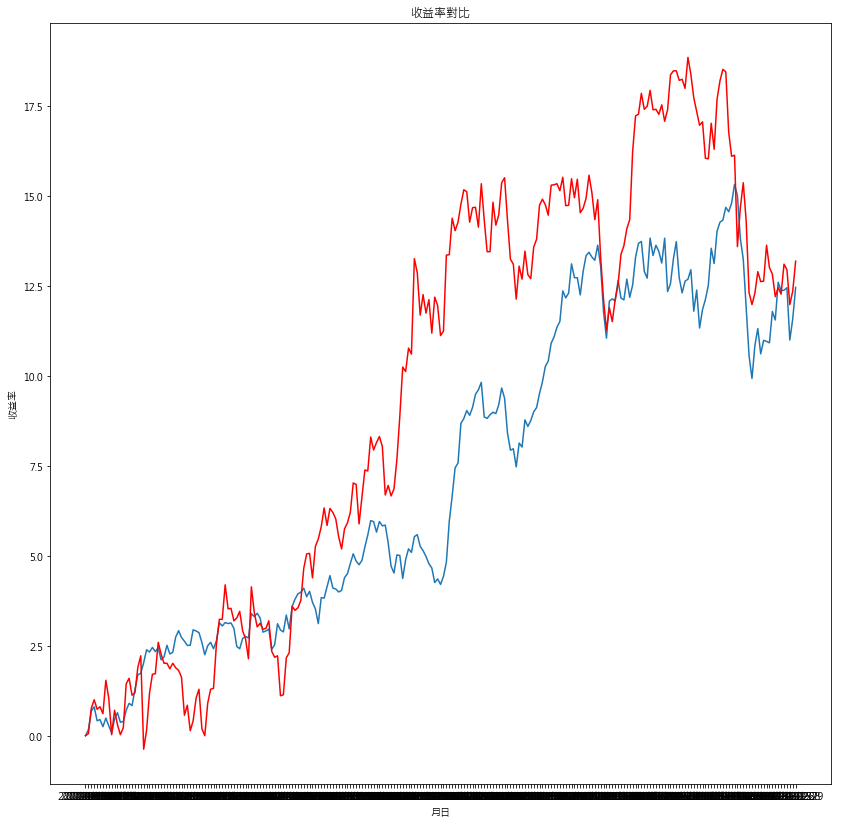

In [72]:
plt.figure(figsize=(14, 14))
plt.xlabel('月日')
plt.ylabel('收益率')
plt.title('收益率對比')
plt.plot(year_date[1:], choose_profit, label='四檔基金')
plt.plot(year_date[1:], compare__profit, color = 'r', label='台灣50')
plt.show()